In [49]:
import os
import numpy as np
import pandas as pd
import random
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt 
import gzip
import pickle
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

In [3]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 

In [4]:
%cd D:/Dataset_1/lastfm-dataset-1K

D:\Dataset_1\lastfm-dataset-1K


In [58]:
PathUser = "D:/Dataset_1/lastfm-dataset-1K/Modelo_Usuario_Usuario/"
PathItem = "D:/Dataset_1/lastfm-dataset-1K/Modelo_Item_Item/"
PathMaestras = "D:/Dataset_1/lastfm-dataset-1K/Matriz_Ratings/Maestras/"

# Carga de archivos

In [5]:
# Definición de nombres de archivos
path_userid = "userid-profile.tsv"
path_userbehavior = "userid-timestamp-artid-artname-traid-traname.tsv"
path_test = "test.tsv"

In [6]:
# Carga de archivos en Dataset
df_Userid = pd.read_csv(path_userid, sep='\t', header=0)
df_Userid.columns = ['user_id', 'gender', 'age', 'country', 'registered']
df_Userbehavior = pd.read_csv(path_userbehavior, sep='\t', usecols=[0, 1,2,3,4,5], header=None)
df_Userbehavior.columns = ['user_id', 'timestamp', 'artid', 'artname', 'traid', 'traname']

In [7]:
# Conversión y tratamiento de variable a tipo 
df_Userbehavior['timestamp'] = df_Userbehavior['timestamp'].astype('datetime64[ns]') 
df_Userbehavior['year'] = pd.DatetimeIndex(df_Userbehavior['timestamp']).year
df_Userbehavior['month'] = pd.DatetimeIndex(df_Userbehavior['timestamp']).month

# Datos descriptivos 

In [8]:
# Total de usuarios registrados
print(df_Userid['user_id'].nunique())
print(df_Userbehavior['user_id'].nunique())

992
992


In [9]:
missing_values_table(df_Userbehavior)

,Missing Values,% of Total Values
user_id,0,0.000000
timestamp,0,0.000000
artid,600853,3.146015
artname,0,0.000000
traid,2162726,11.323847
traname,12,0.000063
year,0,0.000000
month,0,0.000000


In [10]:
# Cantidad total de nombres de artistas escuchados  
print(df_Userbehavior['artname'].nunique())
# Cantidad total de identificación de artistas escuchados  
print(df_Userbehavior['artid'].nunique())

173923
107295


 NO TODOS LOS ARTISTAS TIENEN ID, los que NO corresponde a que no se encuentran en MBID (MUSIC BRAINZ IDENTIFIER)

# CONSTRUCCIÓN DE VARIABLE RAITING

# Es construida con usuarios vs nombres de artistas (estos agrupan información y pueden ser más escalables que las canciones)

In [11]:
df_User_artname = df_Userbehavior[['user_id', 'artname']]
df_User_artname = df_User_artname.drop_duplicates()
df_User_artname.shape

(897421, 2)

In [12]:
# Tabla de frecuencias de usuario - artista
df_agg1 = df_Userbehavior.groupby(['artname' , 'user_id'])['user_id'].agg({'count'})
df_agg1 = df_agg1.reset_index(level=[0,1,])

# Comprobación de totales de dataframe de frecuencias y dataframe original de interacciones
print('Nuevo Dataframe:'+ str(df_agg1['count'].sum()), 'Dataframe Original:'+ str(df_Userbehavior.shape[0]))

#Verificación dataset agregado
df_agg1.sort_values('count', ascending = False).head(5)

Nuevo Dataframe:19098862 Dataframe Original:19098862


,artname,user_id,count
400085,Kanye West,user_000008,26496
144203,Chemistry,user_000141,25609
769610,The Knife,user_000499,18597
678218,Soilwork,user_000889,15566
117555,Britney Spears,user_000084,14614


In [13]:
# Summarized de variable de frecuencia
df_agg1.describe()

,count
count,897421.000000
mean,21.281942
std,118.216548
min,1.000000
25%,1.000000
50%,3.000000
75%,10.000000
max,26496.000000


In [14]:
lista_users = df_Userid.user_id.values

# Cálculo de ratings por usuario y artista
scaler = MinMaxScaler(feature_range=(1,5))
largo = range(len(lista_users))
for i in largo :
    df_tmp = df_agg1[df_agg1.user_id==lista_users[i]]
    df_tmp['rating_lineal'] = scaler.fit_transform(df_tmp[['count']])
    if i == 0:
        df_ratings = df_tmp
    else:
        df_ratings = df_ratings.append(df_tmp, ignore_index=True)



In [15]:
# Validación de completitud
print(df_agg1.shape[0], df_ratings.shape[0])
df_ratings.sort_values('rating_lineal',ascending=False).head(5)

897421 897421


,artname,user_id,count,rating_lineal
226710,Enya,user_000260,1082,5.0
823133,Pj Harvey,user_000914,1781,5.0
334226,The Doors,user_000389,909,5.0
678816,Ac/Dc,user_000761,1122,5.0
130781,Arcade Fire,user_000143,6,5.0


In [16]:
def rating_global(x):
    x = round(x)
    if (x>=1 and x< 2 ):
        return 1
    else:
        if (x>=2 and x<3):
            return 2
        else:
            if (x>=3 and x<4):
                return 3
            else:
                if (x>=4 and x< 5):
                    return 4
                else:
                    if (x>=5):
                        return 5

In [17]:
# Aplicación de función
df_ratings['rating_agregado'] = df_ratings.rating_lineal.apply(rating_global)
# Agregación de resultados para mostrar gráfica
df_ratings_final = df_ratings.groupby(['rating_agregado'])['count'].agg({'sum'})
df_ratings_final = df_ratings_final.reset_index(level=[0])
#df_ratings_final.plot.line(x='rating_agregado', y='sum', figsize=(10,10))

# Una nueva Matriz de Ratings es construida con usuarios, nombres de artistas, año y mes que fue escuchada la canción. Se adicionan las variables mes y el año con el fin de segregar lo mayor posible información

In [18]:
df_agg2 = df_Userbehavior.groupby(['artname' , 'user_id', 'year', 'month'])['user_id'].agg({'count'})
df_agg2 = df_agg2.reset_index(level=[0,1,2,3])
print(df_agg2['count'].sum(), df_Userbehavior.shape[0])

19098862 19098862


In [19]:
# Estandarización de variable de frecuencia con LN para disminuir la sensibilidad que podrucen los extremos en la muestra
df_agg3 = df_agg2.copy()
df_agg3['count_ln']= np.log10(df_agg3['count'])
df_agg3.describe()

,year,month,count,count_ln
count,3.125721e+06,3.125721e+06,3.125721e+06,3.125721e+06
mean,2.007305e+03,6.321702e+00,6.110226e+00,3.772827e-01
std,1.106306e+00,3.528801e+00,2.339222e+01,4.771698e-01
min,2.005000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.006000e+03,3.000000e+00,1.000000e+00,0.000000e+00
50%,2.007000e+03,6.000000e+00,2.000000e+00,3.010300e-01
75%,2.008000e+03,9.000000e+00,4.000000e+00,6.020600e-01
max,2.013000e+03,1.200000e+01,1.018800e+04,4.008089e+00


In [20]:
for i in largo :
    df_tmp1 = df_agg3[df_agg3.user_id==lista_users[i]]
    df_tmp1['rating_lineal'] = scaler.fit_transform(df_tmp1[['count_ln']])
    if i == 0:
        df_ratings3 = df_tmp1.copy()
    else:
        df_ratings3 = df_ratings3.append(df_tmp1, ignore_index=True)

In [21]:
df_ratings_final1 = df_ratings3.groupby(['artname', 'user_id']).agg({'count':'sum', 'rating_lineal':'median'})
df_ratings_final1 = df_ratings_final1.reset_index(level=[0,1])
# Aplicación de función
df_ratings_final1['rating_agregado'] = df_ratings_final1.rating_lineal.apply(rating_global)

# Agregación de resultados para mostrar gráfica
df_ratings_fin1 = df_ratings_final1.groupby(['rating_agregado'])['count'].agg({'sum'})
df_ratings_fin1 = df_ratings_fin1.reset_index(level=[0])

# Construcción de matriz de ratings por usuario y artista con las caracteristicas de usuario, artista, año y mes

In [22]:
resultArray = []
lista_users = df_Userid.user_id.values
for i in range(len(lista_users)) :
    user = lista_users[i]
    general = df_agg3[df_agg3.user_id == user].to_numpy()
    lista_artistas = df_agg1[df_agg1['user_id']==user]['artname'].values 
    for j in range(len(lista_artistas)):
        artista = lista_artistas[j]
        usuarioartista = list(filter(lambda x: (x[0]==artista) ,general))  #Aquí se quito un filtro
        usuarioartista = np.array(usuarioartista)
        Normalizacion  = scaler.fit_transform(usuarioartista[:,[4]])
        usuarioartista = np.append(usuarioartista, Normalizacion, axis=1)
        resultArray.append(usuarioartista)

In [23]:
# Conversión multitupla a Dataframe
columnas = ['artname', 'user_id', 'year', 'month', 'count', 'count_ln', 'rating_lineal']
df_ratings4 = pd.DataFrame(np.concatenate(resultArray), columns = columnas )
df_ratings4.year=df_ratings4.year.astype('int64')
df_ratings4.month=df_ratings4.month.astype('int64')
df_ratings4['count']=df_ratings4['count'].astype('int64')
df_ratings4.count_ln=df_ratings4.count_ln.astype('float64')
df_ratings4.rating_lineal=df_ratings4.rating_lineal.astype('float64')

In [24]:
df_ratings_final2 = df_ratings4.groupby(['artname', 'user_id']).agg({'count':'sum', 'rating_lineal':'median'})
df_ratings_final2 = df_ratings_final2.reset_index(level=[0,1])
# Aplicación de función
df_ratings_final2['rating_agregado'] = df_ratings_final2.rating_lineal.apply(rating_global)
# Agregación de resultados para mostrar gráfica
df_ratings_fin2 = df_ratings_final2.groupby(['rating_agregado'])['count'].agg({'sum'})
df_ratings_fin2 = df_ratings_fin2.reset_index(level=[0])

In [25]:
# Tabla de distribuciones
df_estadisticas = df_ratings_fin1.merge(df_ratings_final[['rating_agregado', 'sum']], how='left', on = 'rating_agregado')
df_estadisticas = df_estadisticas.merge(df_ratings_fin2[['rating_agregado', 'sum']], how='left', on = 'rating_agregado')
df_estadisticas = df_estadisticas.rename(columns={"sum_x": "Test2", "sum_y": "Test1", "sum":"Test3"})
df_estadisticas

,rating_agregado,Test2,Test1,Test3
0,1,3334511,9559440,10119640
1,2,7664467,5299939,6503756
2,3,6365314,1894419,2082665
3,4,1646963,932635,281677
4,5,87607,1412429,111124


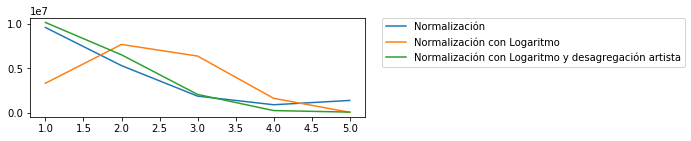

In [26]:
x_values1= df_ratings_final.rating_agregado.values
y_values1= df_ratings_final['sum'].values

x_values2=df_ratings_fin1.rating_agregado.values
y_values2=df_ratings_fin1['sum'].values

x_values3=df_ratings_fin2.rating_agregado.values
y_values3=df_ratings_fin2['sum'].values

plt.subplot(212)

plt.plot(x_values1, y_values1, label="Normalización")
plt.plot(x_values2, y_values2,  label="Normalización con Logaritmo")
plt.plot(x_values3, y_values3,  label="Normalización con Logaritmo y desagregación artista")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

#  Comparación de un rating para un usuario y un artista con las técnicas 

In [28]:
df_ratings[(df_ratings.artname == '4Hero') & (df_ratings.user_id == 'user_000001')]

,artname,user_id,count,rating_lineal,rating_agregado
4,4Hero,user_000001,146,1.679157,2


In [29]:
df_ratings_final1[(df_ratings_final1.artname == '4Hero') & (df_ratings_final1.user_id == 'user_000001')]

,artname,user_id,count,rating_lineal,rating_agregado
5948,4Hero,user_000001,146,2.062899,2


In [30]:
df_ratings_final2[(df_ratings_final2.artname == '4Hero') & (df_ratings_final2.user_id == 'user_000001')]

,artname,user_id,count,rating_lineal,rating_agregado
5948,4Hero,user_000001,146,1.290909,1


# Gráfica Long Tail

In [31]:
df_longtail = df_agg1.groupby(['artname'])['count'].agg({'count'}).reset_index()
df_longtail = df_longtail.sort_values('count', ascending = False)

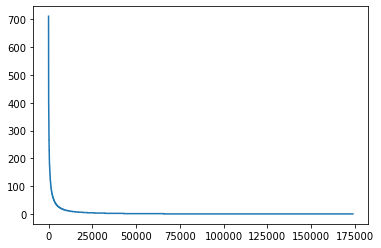

In [32]:
plt.plot(list(range(len(df_longtail['count']))), df_longtail["count"])

# Creación de tablas maestras de usuarios y artistas con dataset de ratings seleccionado

In [27]:
#Valores únicos por artista y usuario
print(df_ratings_final1.artname.nunique())
print(df_ratings_final1.user_id.nunique())

173923
992


In [33]:
#Conversión en valor id a los usuarios y artistas
df_ratings_modif = df_ratings_final1
artistas = df_ratings_modif[['artname']].drop_duplicates()
users = df_ratings_modif[['user_id']].drop_duplicates()
artistas.insert(0, 'New_ID_A', range(0, len(artistas)))
users.insert(0, 'New_ID', range(0, len(users)))
df_ratings_modif = df_ratings_modif.merge(users[['user_id', 'New_ID']], how='left', left_on = 'user_id', right_on = 'user_id')
df_ratings_modif = df_ratings_modif.merge(artistas[['artname', 'New_ID_A']], how='left', left_on = 'artname', right_on = 'artname')
#df_ratings_modificado = df_ratings_modif[['New_ID', 'New_ID_A', 'rating_lineal']]
#df_ratings_modificado.columns = ['user_id', 'artname', 'rating_lineal']

# Verficación de claves generadas

print(df_ratings_modif.artname.nunique())
print(df_ratings_modif.user_id.nunique())

173923
992


#  Exportación archivo de ratings con claves numericas en usuario y artista 

In [59]:
# Creación Tablas Maestras
df_users_id = df_ratings_modif[['user_id','New_ID']].drop_duplicates()
df_users_id.columns = ['user_id', 'new_user_id']

df_artists_id = df_ratings_modif[['artname','New_ID_A']].drop_duplicates()
df_artists_id.columns = ['artname', 'new_artist_id']

# Exportación tablas maestras
df_users_id.to_pickle(PathMaestras+"Maestra_Usuarios.pkl")
df_artists_id.to_pickle(PathMaestras+"Maestra_Artistas.pkl")


In [60]:
# Matriz de utilidad para modelo Usuario - Usuario
df_ratings_modif1 = df_ratings_modif[['New_ID', 'New_ID_A','rating_lineal']]
df_ratings_modif1.columns = ['user_id', 'artname', 'rating_lineal']
df_ratings_modif1.to_pickle(PathUser+"Ratings_Normalizacion_Log.pkl")

# Exportación de resultados de ratings
#df_ratings[['artname', 'user_id', 'rating_lineal']].to_pickle("./Ratings_Normalizacion.pkl")
#df_ratings_final1[['artname', 'user_id', 'rating_lineal']].to_pickle("./Ratings_Normalizacion_Log.pkl")
#df_ratings_final2[['artname', 'user_id', 'rating_lineal']].to_pickle("./Ratings_Normalizacion_Log_Desagregado.pkl")

In [62]:
# Matriz de Utilidad para modelo Item - Item 
    # Ratings con variable de cantidad de interacciones
df_ratings_modif_item = df_ratings_modif[['New_ID', 'New_ID_A', 'count','rating_lineal']]
df_ratings_modif_item.columns = ['user_id', 'artname', 'count','rating_lineal']
f = gzip.open(PathItem + '0.Ratings_Completos.pklz','wb')
pickle.dump(df_ratings_modif_item,f)
f.close()

# Reducción de tamaño de matriz para procesamiento
df_ratings_modif_item_final = df_ratings_modif_item.loc[df_ratings_modif_item['count'] >= 7,['user_id', 'artname', 'rating_lineal']]
df_ratings_modif_item_final.to_pickle(PathItem +"1.Ratings_Normalizacion_Log.pkl")